## CLM-PPE History Matching Wave 1 February 2024

#### PFTxBiome ecoregions 
#### LAI and GPP 

## Section 1: Train Emulators

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score
from pyfunctions import *
import warnings
warnings.filterwarnings("ignore")

2024-02-13 16:46:55.757239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 16:46:56.240367: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 16:46:56.356173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

### Load Data

In [26]:
laimax_pxb=xr.open_dataset('lai_amax_pxb_2003-2007.nc')
laimax_pxb = laimax_pxb.rename({'__xarray_dataarray_variable__': 'TLAI'})

In [27]:
laimean_pxb=xr.open_dataset('lai_amean_pxb_2003-2007.nc')
laimean_pxb = laimean_pxb.rename({'__xarray_dataarray_variable__': 'TLAI'})

In [62]:
gpp_pxb=xr.open_dataset('gpp_amean_pxb_2001-2010_v2.nc')

In [10]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [11]:
whit=xr.open_dataset('whit/whitkey.nc')
biome_names = whit.biome_name.values
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

In [12]:
pb_index = np.load('pb_index.npy', allow_pickle=True).item()

In [13]:
# Define kernels
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

2024-02-13 16:51:40.392383: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-13 16:51:40.392445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc52): /proc/driver/nvidia/version does not exist
2024-02-13 16:51:40.432398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train GPP Emulators

INFO:tensorflow:Assets written to: ./models_gpp/pft1_biome2/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft1_biome5/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft1_biome6/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft1_biome7/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft1_biome8/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft2_biome4/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft2_biome5/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft2_biome6/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft2_biome8/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft2_biome9/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft3_biome8/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft3_biome9/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft4_biome1/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft4_biome2/assets
INFO:tensorflow:Assets written to: ./models_gpp/pft4_biome3/as

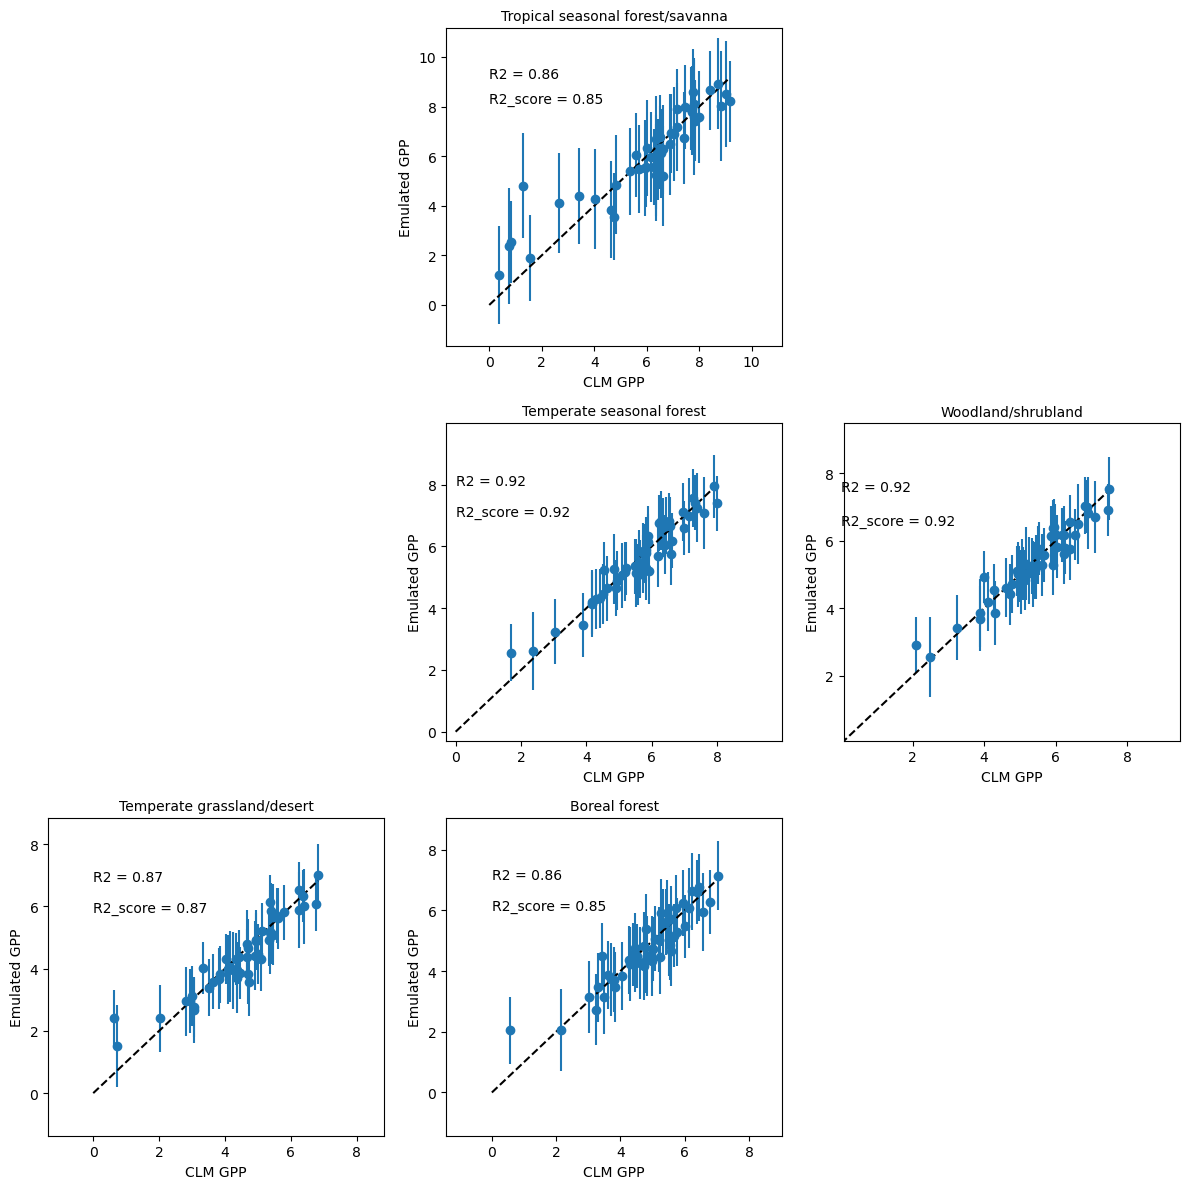

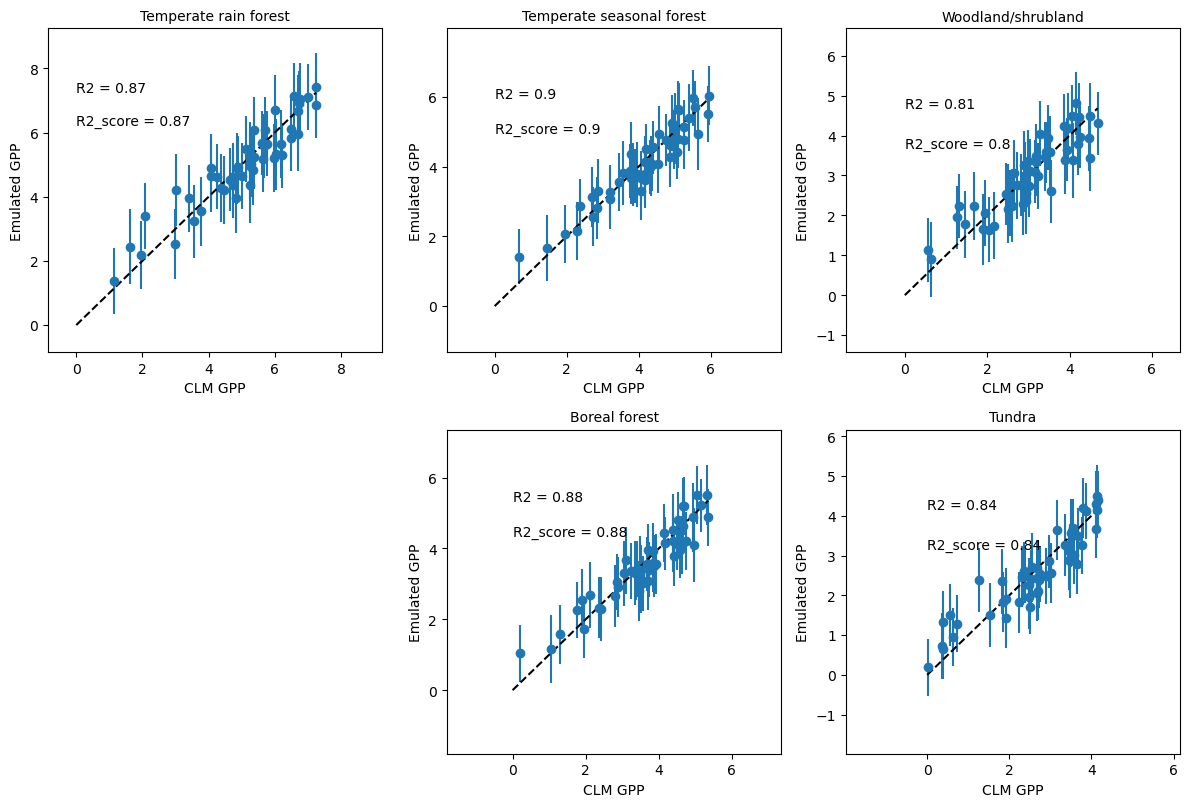

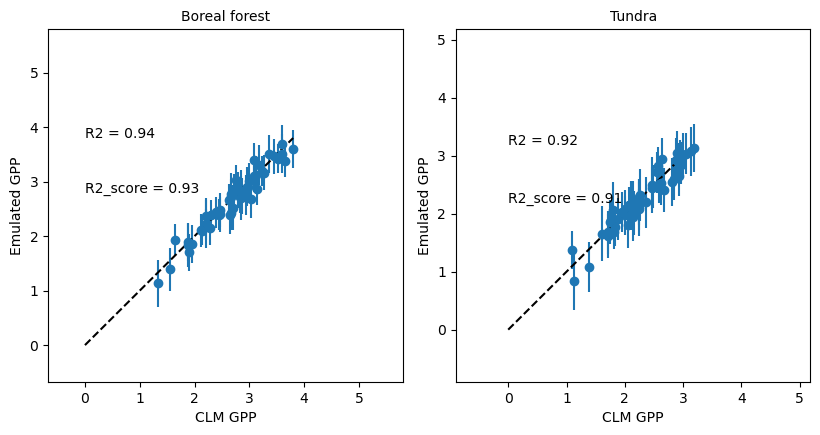

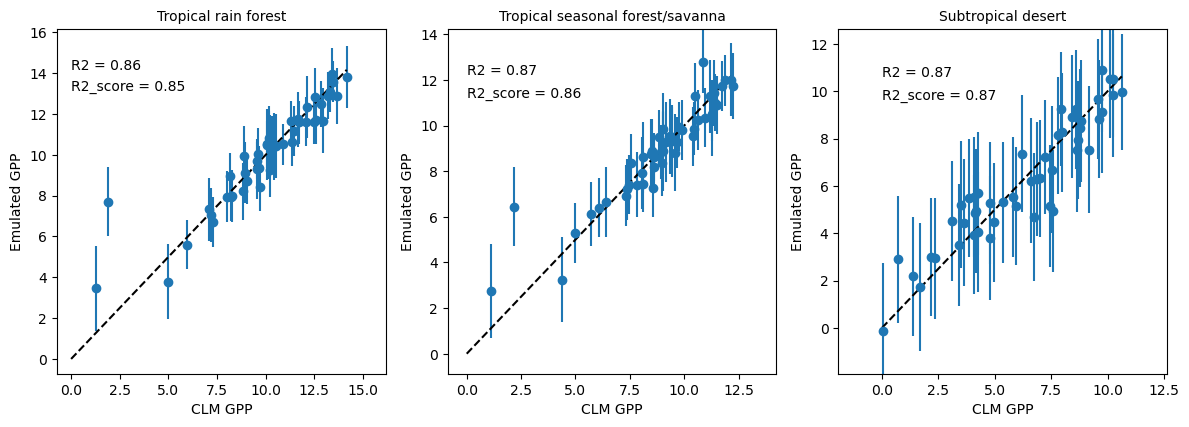

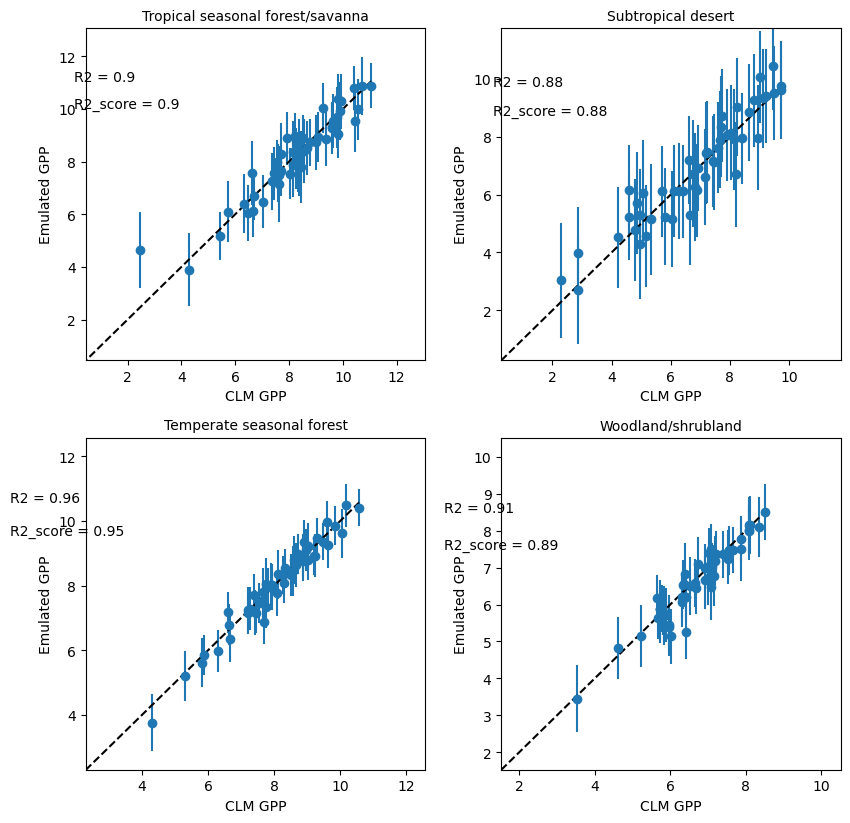

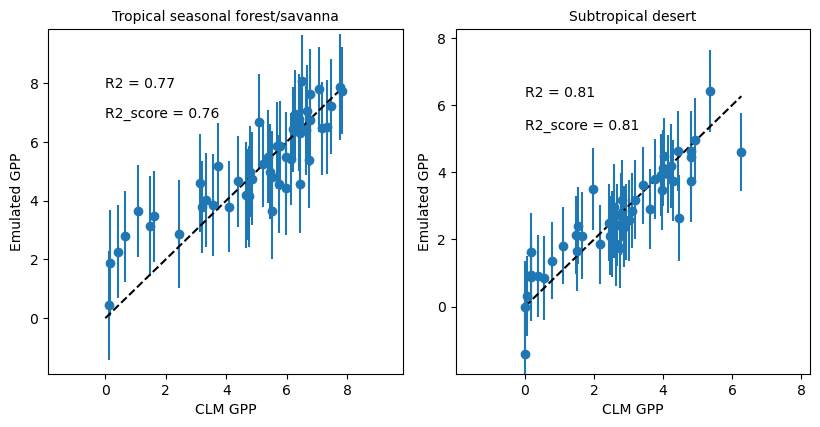

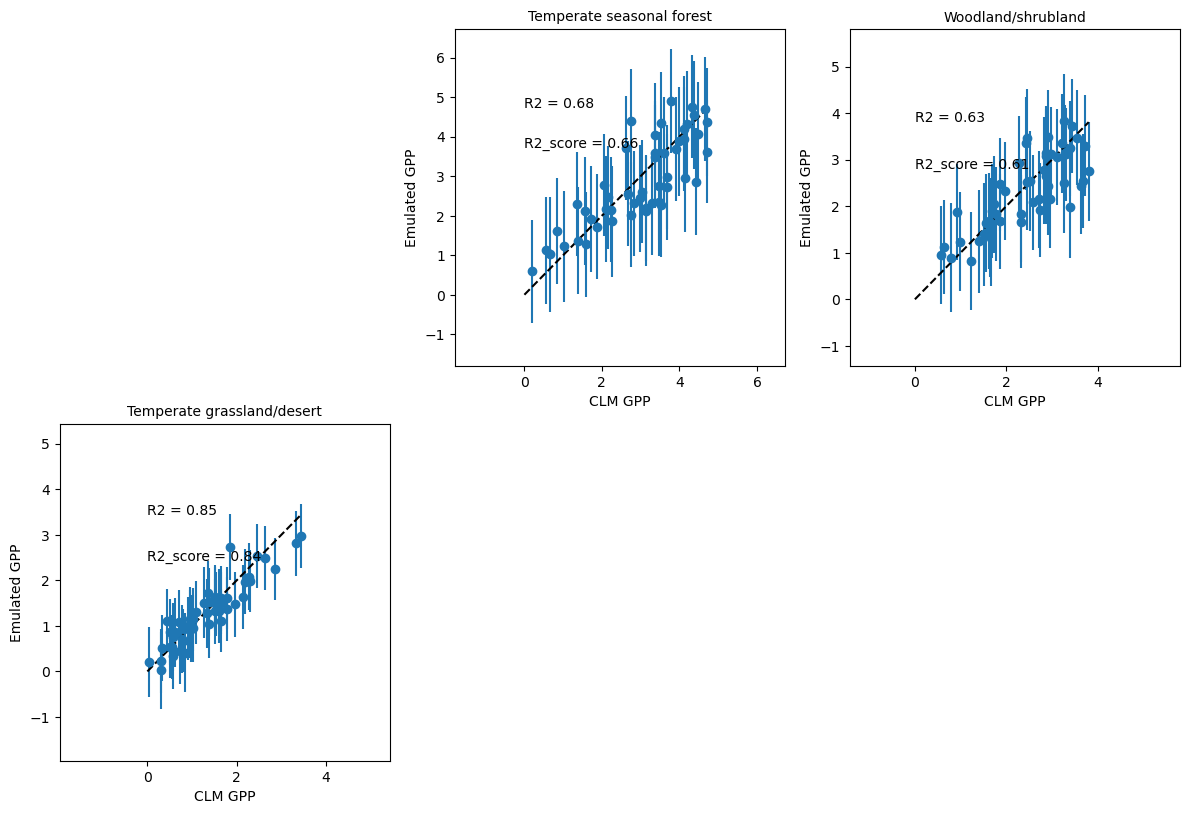

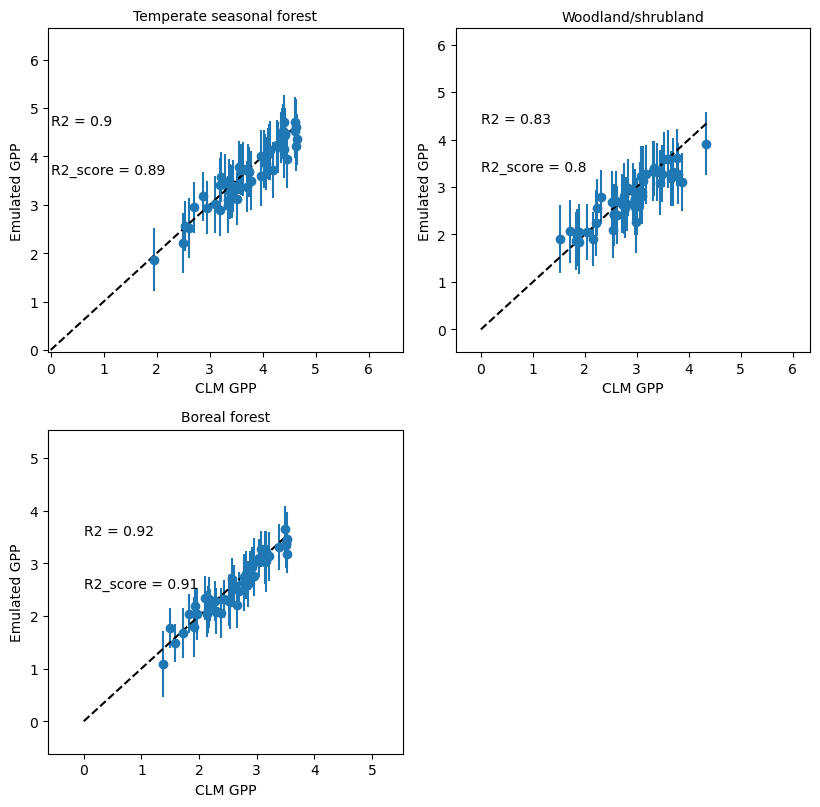

<Figure size 1200x1200 with 0 Axes>

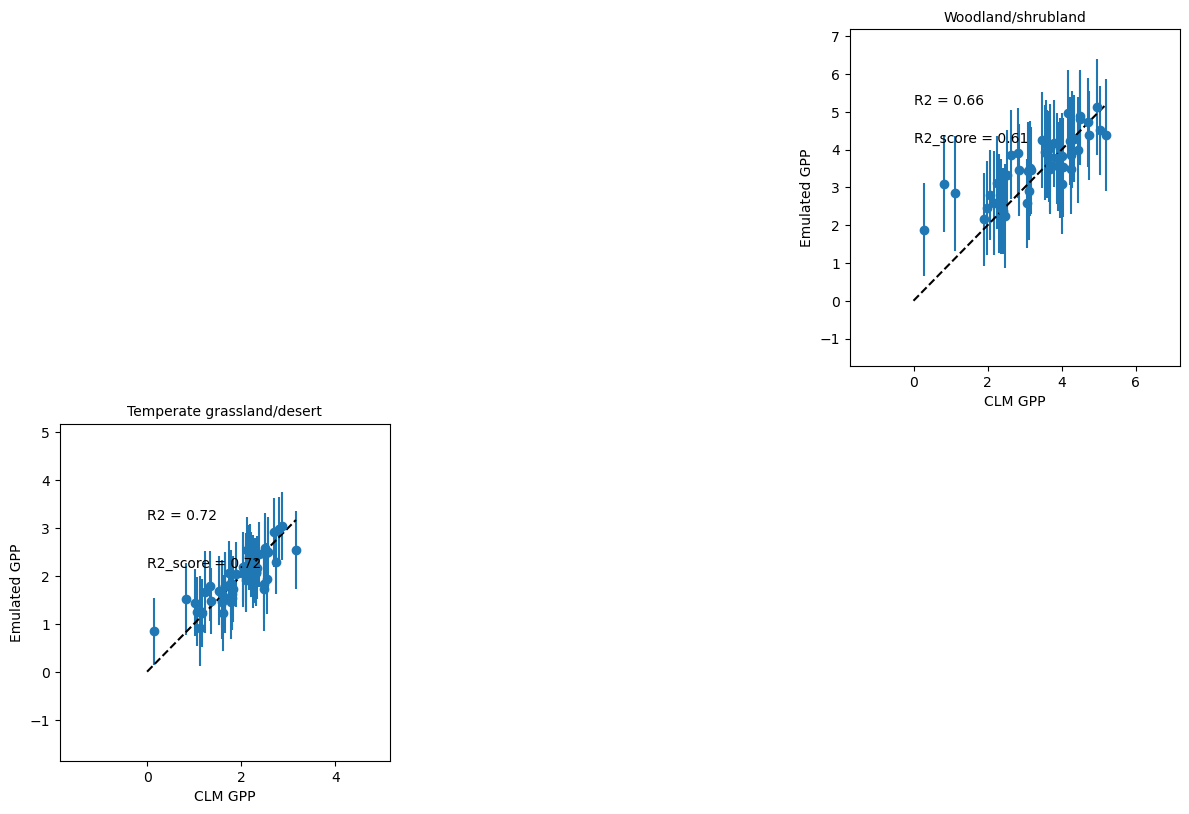

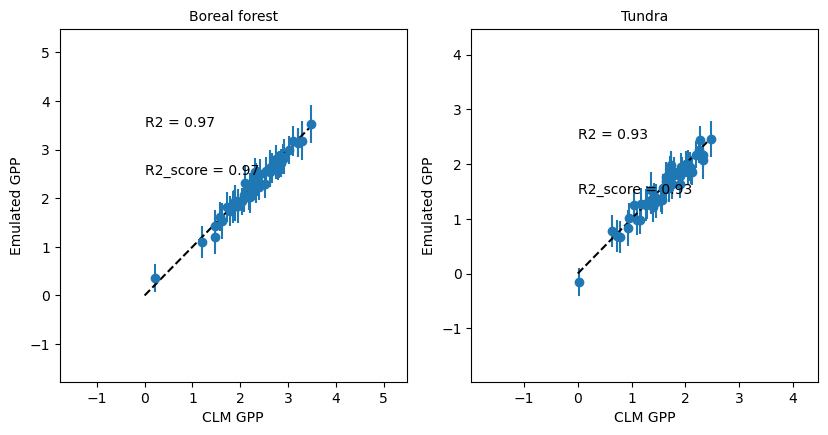

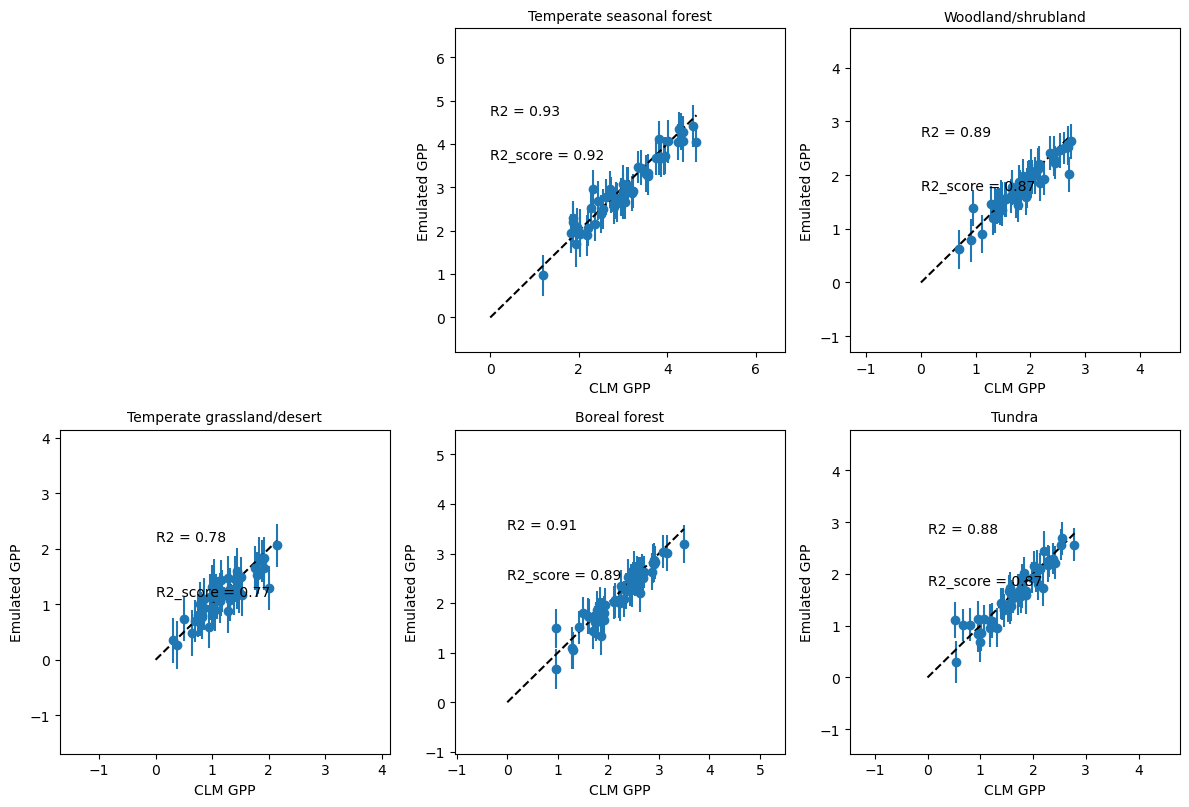

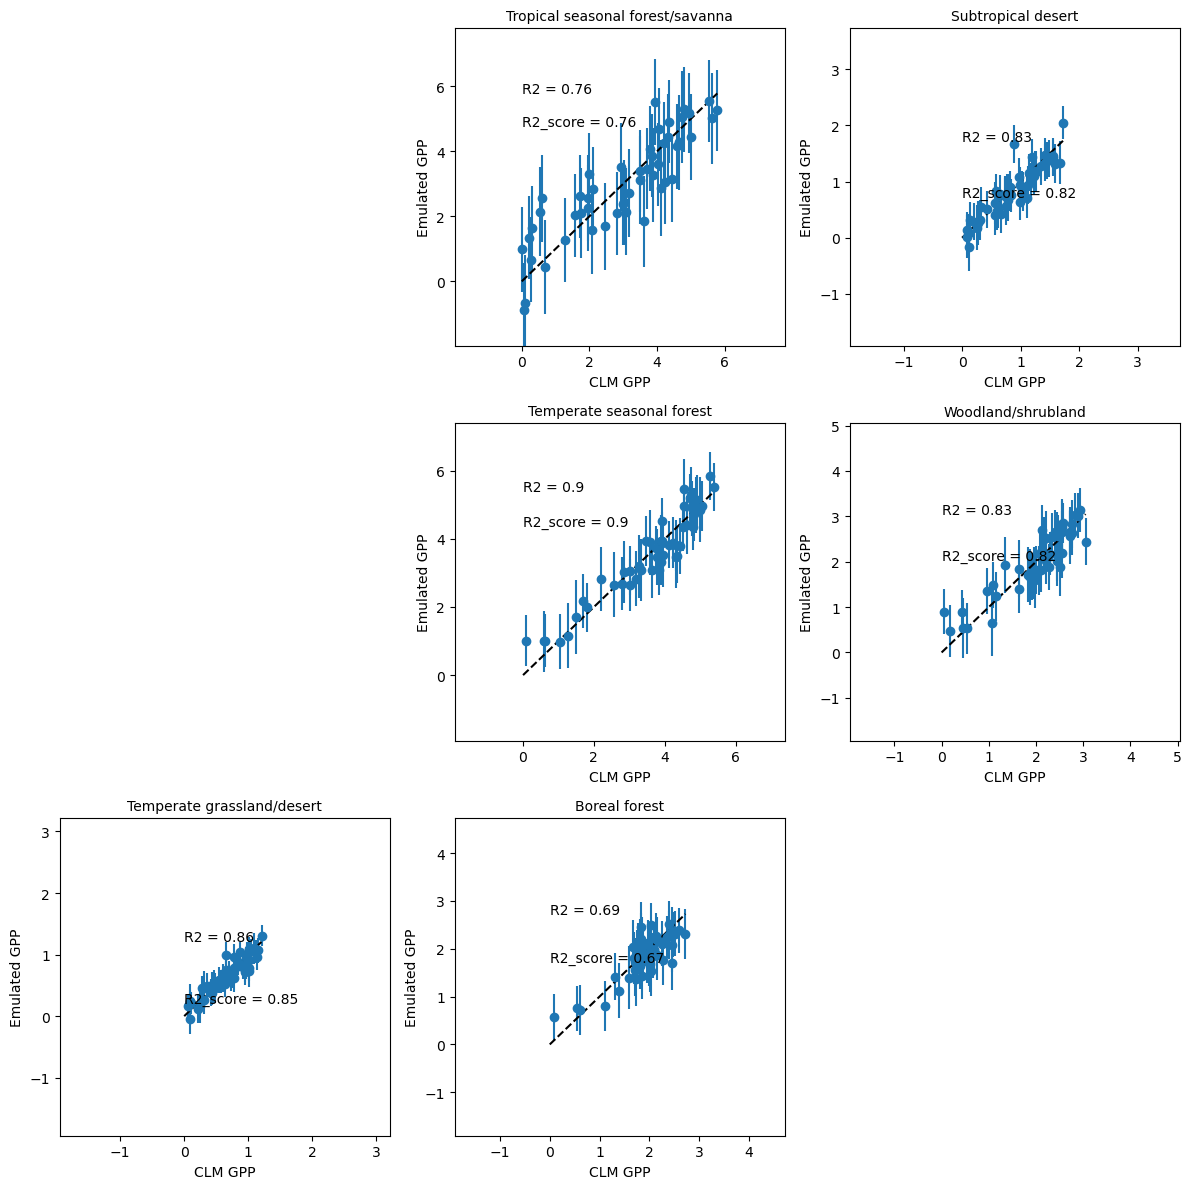

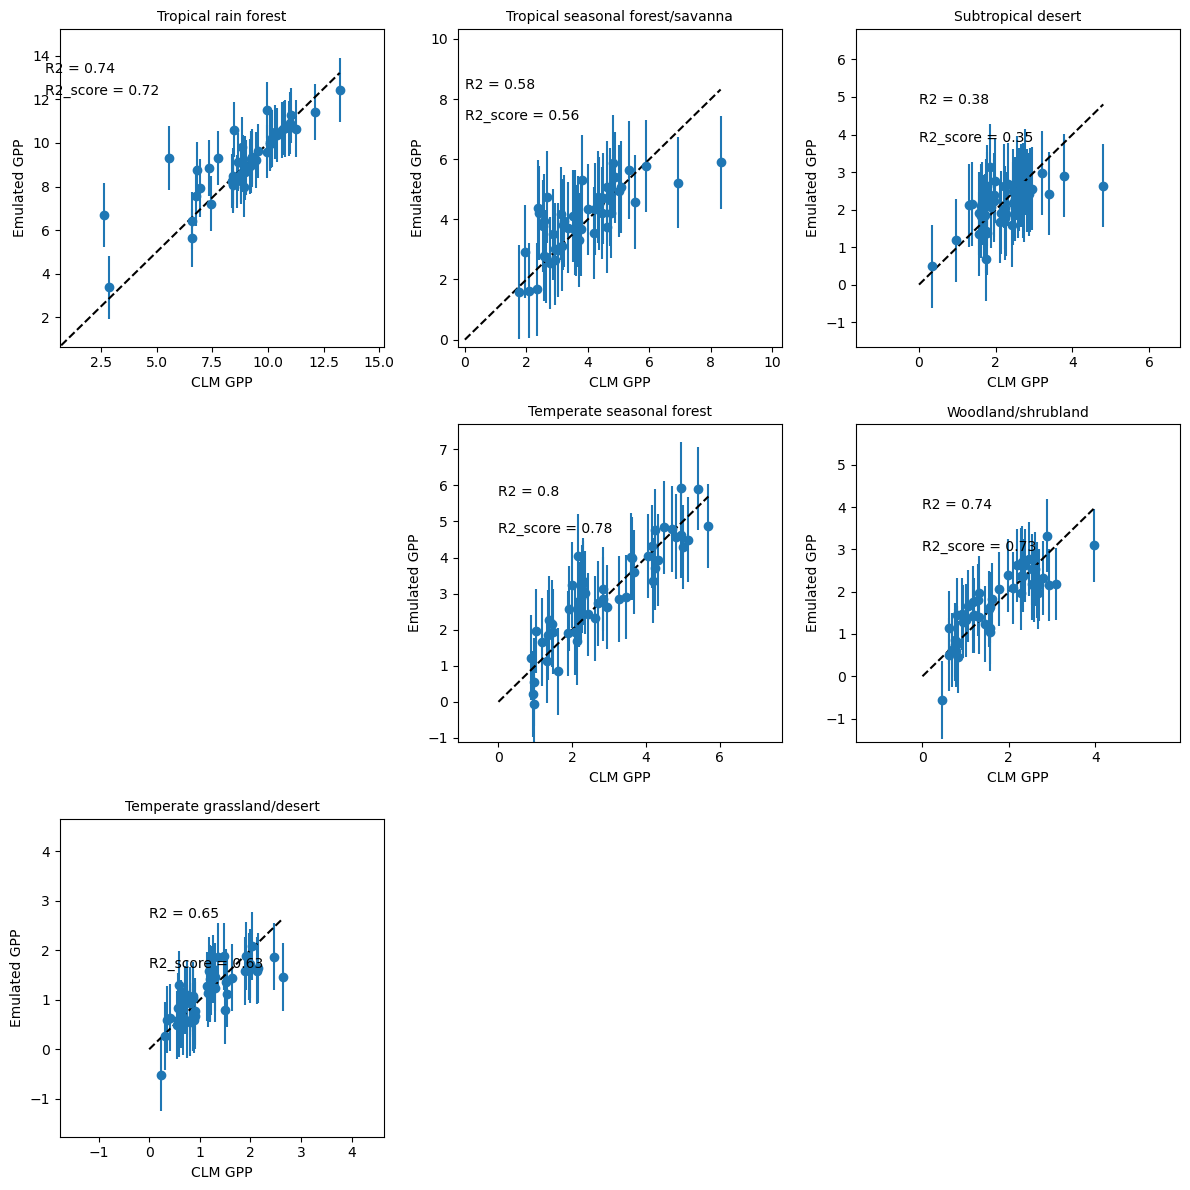

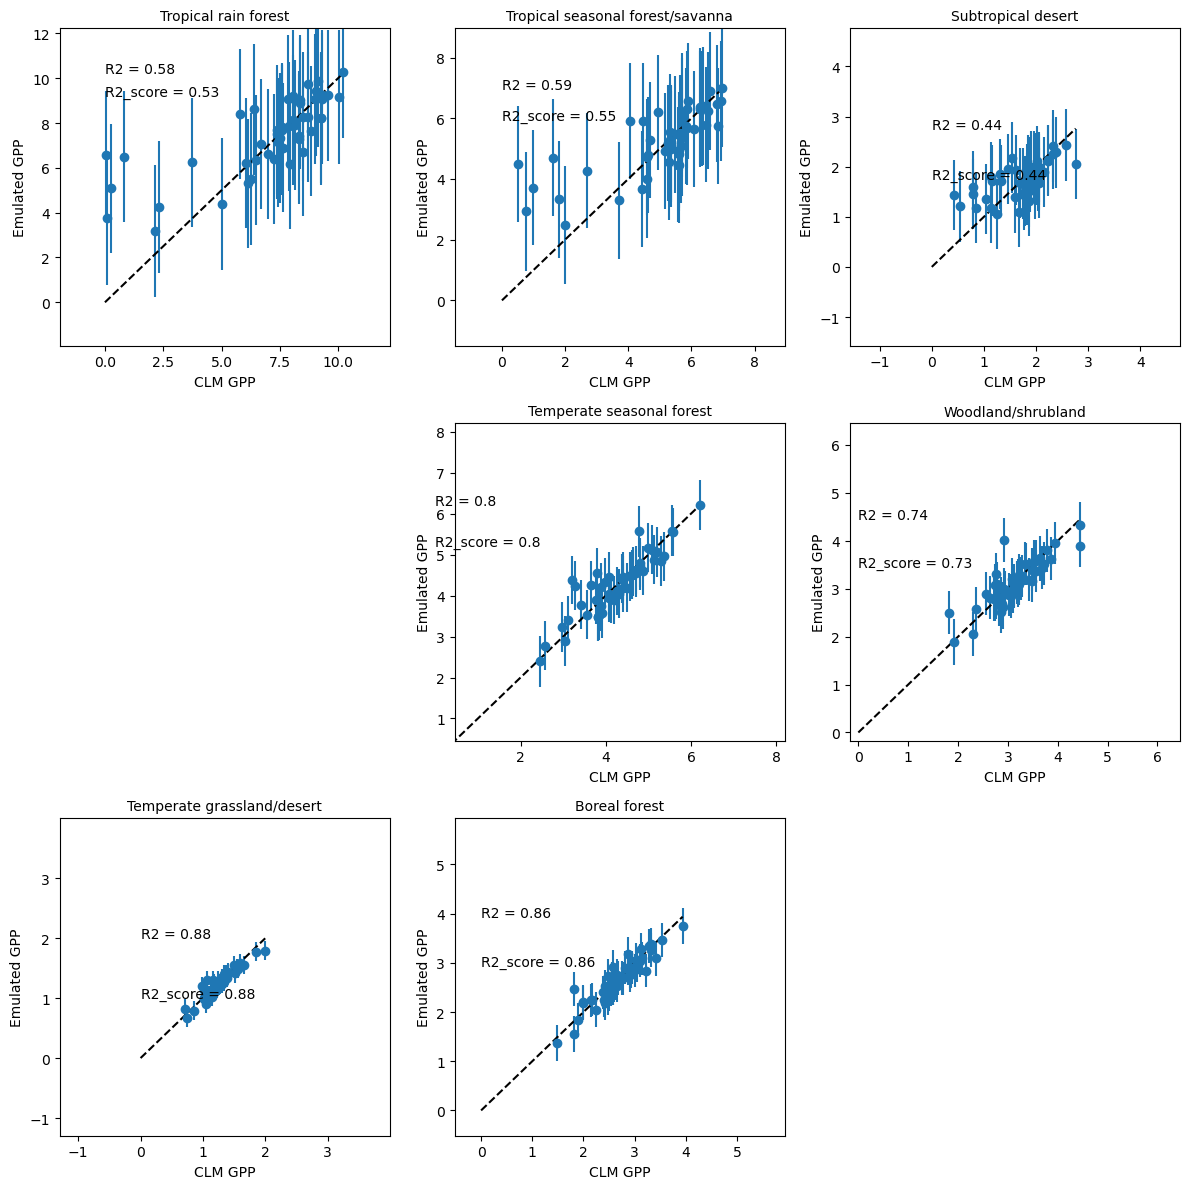

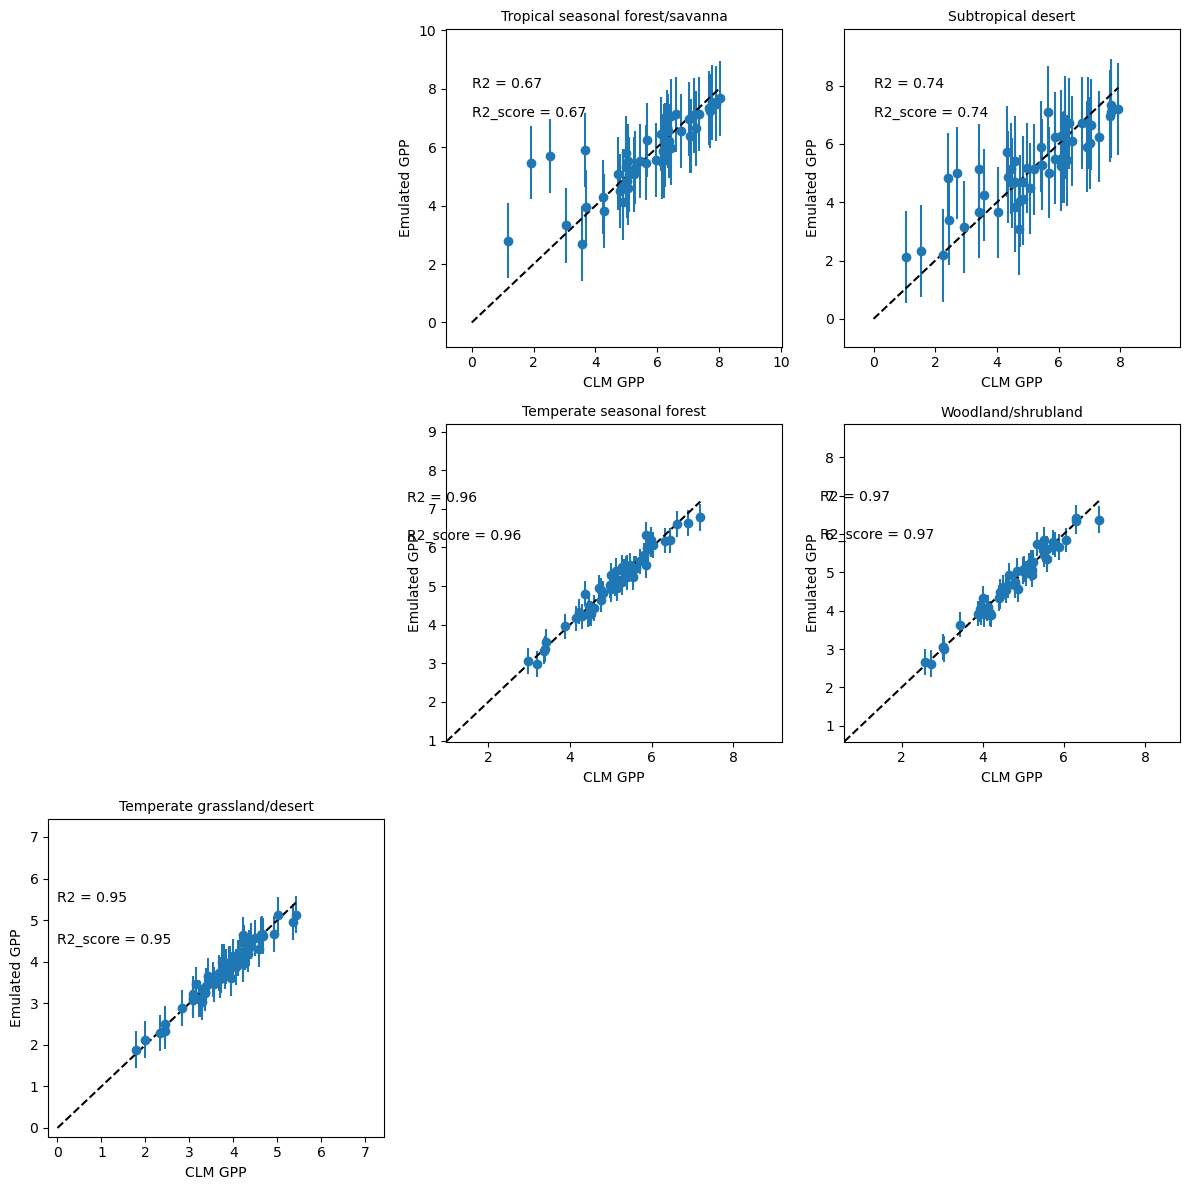

In [64]:
# Train emulators
scaler = 24*60*60 # convert to gC/m2/day
R2_score = np.empty((17, 10))*np.NaN

# select the kernal to use
#kernel = kernel_linear + kernel_RBF + kernel_poly + kernel_bias
kernel = kernel_linear*kernel_RBF+kernel_matern32 + kernel_bias

for p in range(1,17):
    plt.figure(figsize=[12,12])
    plt.rcParams.update({'font.size': 10})

    da_p = gpp_pxb.isel(pxb=gpp_pxb.pft==p)

    for i,b in enumerate(pb_index[pft_names[p]]):
        da_pb = da_p.isel(pxb=da_p.biome==b)
        
        X_train, X_test = lhc_params.iloc[50:,:].values, lhc_params.iloc[:50,:].values
        y_train, y_test = scaler*da_pb.GPP[0][51:].values.reshape(-1,1), scaler*da_pb.GPP[0][1:51].values.reshape(-1,1)

        model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1200))

        # save model
        model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
        savedir = str('./models_gpp/pft'+str(p)+'_biome'+str(b))
        tf.saved_model.save(model, savedir)
        
        # plot validation
        y_pred, y_pred_var = model.predict_y(X_test)
        sd = y_pred_var.numpy().flatten()**0.5
        
        r = np.corrcoef(y_test.flatten(),y_pred.numpy().flatten())
        r2 = r[0,1]**2
        coef_deter = r2_score(y_test.flatten(),y_pred.numpy())
        R2_score[p,b] = coef_deter
        
        plt.subplot(3,3,b)
        plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
        plt.text(0,np.max(y_test.flatten()),'R2 = '+str(np.round(r2,2)),fontsize=10)
        plt.text(0,np.max(y_test.flatten())-1,'R2_score = '+str(np.round(coef_deter,2)),fontsize=10)
        plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_test.flatten())],linestyle='--',c='k')
        plt.xlabel('CLM GPP')
        plt.ylabel('Emulated GPP')
        plt.xlim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.ylim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.title(biome_names[b],fontsize=10)
        
    plt.tight_layout()
    plt.savefig('./figs/GPPemulator_validation_pft'+str(p)+'.png')

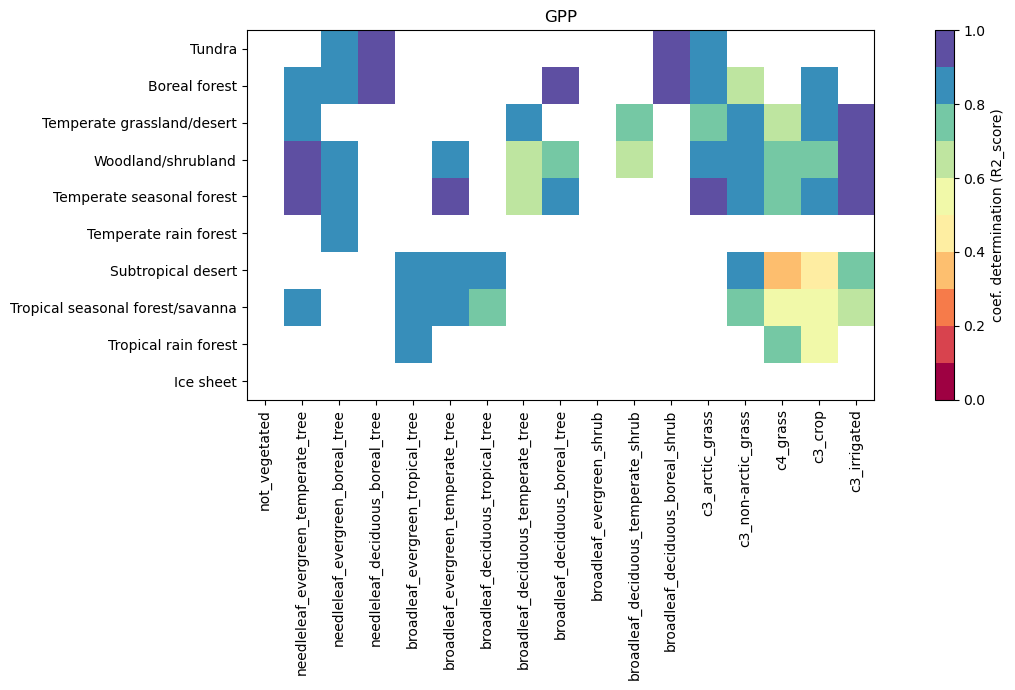

In [65]:
### Plot emulator evalutation
df_r2 = pd.DataFrame(R2_score)
df_r2.index = pft_names[0:17]
df_r2.columns = biome_names

plt.figure(num=None, figsize=(14, 7), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
data = df_r2.transpose().iloc[::-1]
cmap = plt.get_cmap('Spectral', 10)

im = ax.imshow(data,cmap=cmap,vmin=0,vmax=1)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(10), labels=data.index)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xticks(np.arange(17), labels=data.columns,rotation = 90)
plt.title('GPP')
plt.tight_layout()

cbar = plt.colorbar(im)
cbar.set_label("coef. determination (R2_score)")
plt.savefig('./figs/R2score_GPP_PxB.png')

In [66]:
# get land area
f='/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc'
lapxb=xr.open_dataset(f).lapxb
v = lapxb.sum(dim='pft').sel(year=slice(2001,2010)).mean(dim='year').compute()

la_array = v.isel(pxb=10*np.arange(1,16,1)).values
for b in range(1,10):
    ix = b+10*np.arange(1,16,1)
    new_column = v.isel(pxb=ix).values
    la_array = np.column_stack((la_array, new_column))


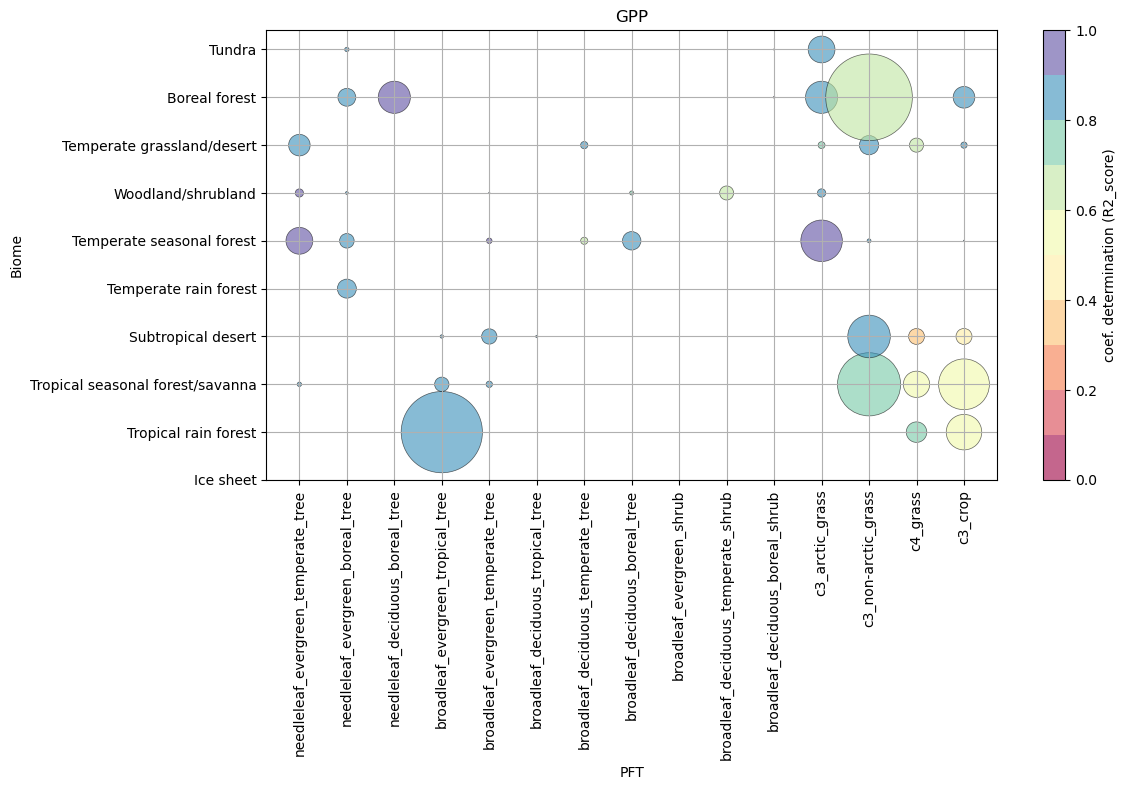

In [67]:
# same figure - scatter - sized by PxB land area
data = np.transpose(df_r2.iloc[range(1,16)].values)
num_rows, num_cols = data.shape

# Create X and Y index arrays using numpy.meshgrid
x_indices, y_indices = np.meshgrid(np.arange(num_cols), np.arange(num_rows))

# Flatten the index arrays and the data array
x_indices_flat = x_indices.flatten()
y_indices_flat = y_indices.flatten()
data_flat = data.flatten()

# Create scatter plot
plt.figure(num=None, figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
plt.scatter(x_indices_flat, y_indices_flat, c=data_flat, cmap=cmap, s=np.transpose(la_array)/3000, edgecolors='black', linewidths=0.5,alpha = 0.6, vmin=0,vmax=1)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(10), labels=df_r2.iloc[range(1,16)].columns)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xticks(np.arange(15), labels=df_r2.iloc[range(1,16)].index, rotation=90)
plt.title('GPP')
plt.tight_layout()

plt.colorbar(label='coef. determination (R2_score)')
plt.ylabel('Biome')
plt.xlabel('PFT')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/R2score_GPP_PxB_laScaled.png')

### Train LAI emulators

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./models_lai/pft1_biome2/assets
INFO:tensorflow:Assets written to: ./models_lai/pft1_biome5/assets
INFO:tensorflow:Assets written to: ./models_lai/pft1_biome6/assets
INFO:tensorflow:Assets written to: ./models_lai/pft1_biome7/assets
INFO:tensorflow:Assets written to: ./models_lai/pft1_biome8/assets
INFO:tensorflow:Assets written to: ./models_lai/pft2_biome4/assets
INFO:tensorflow:Assets written to: ./models_lai/pft2_biome5/assets
INFO:tensorflow:Assets written to: ./models_lai/pft2_biome6/assets
INFO:tensorflow:Assets written to: ./models_lai/pft2_biome8/assets
INFO:tensorflow:Assets written to: ./models_lai/pft2_biome9/assets
INFO:tensorflow:Assets written to: ./models_lai/pft3_biome8/assets
INFO:tensorflow:Assets written to: ./models_lai/pft3_biome9/assets
INFO:tensorflow:Assets written to: ./models_lai/pft4_biome1/assets
INFO:tensorflow:

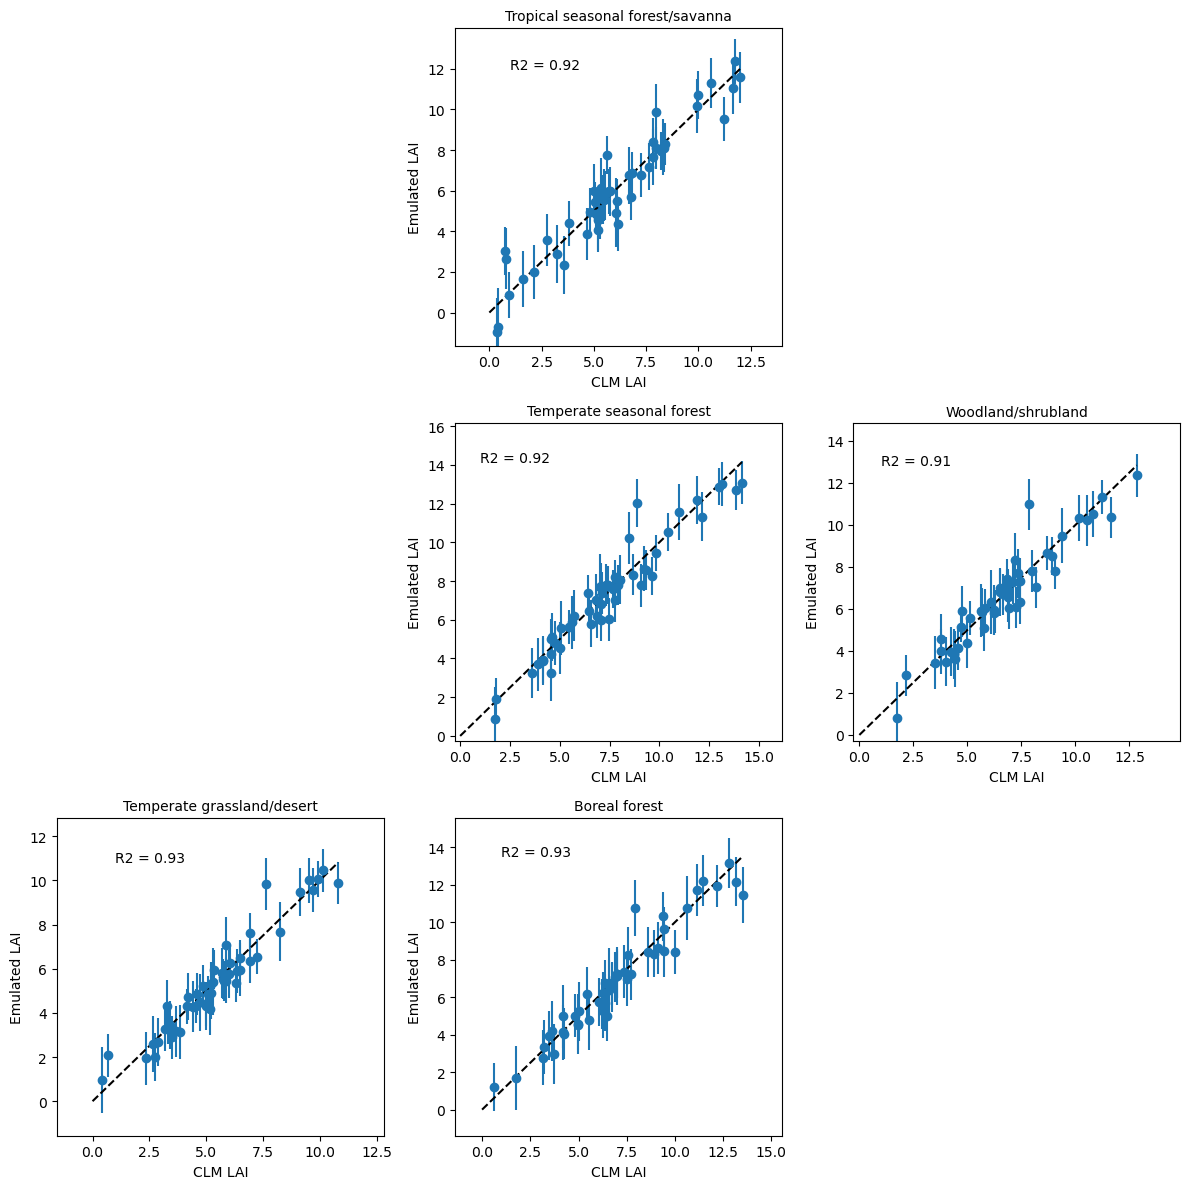

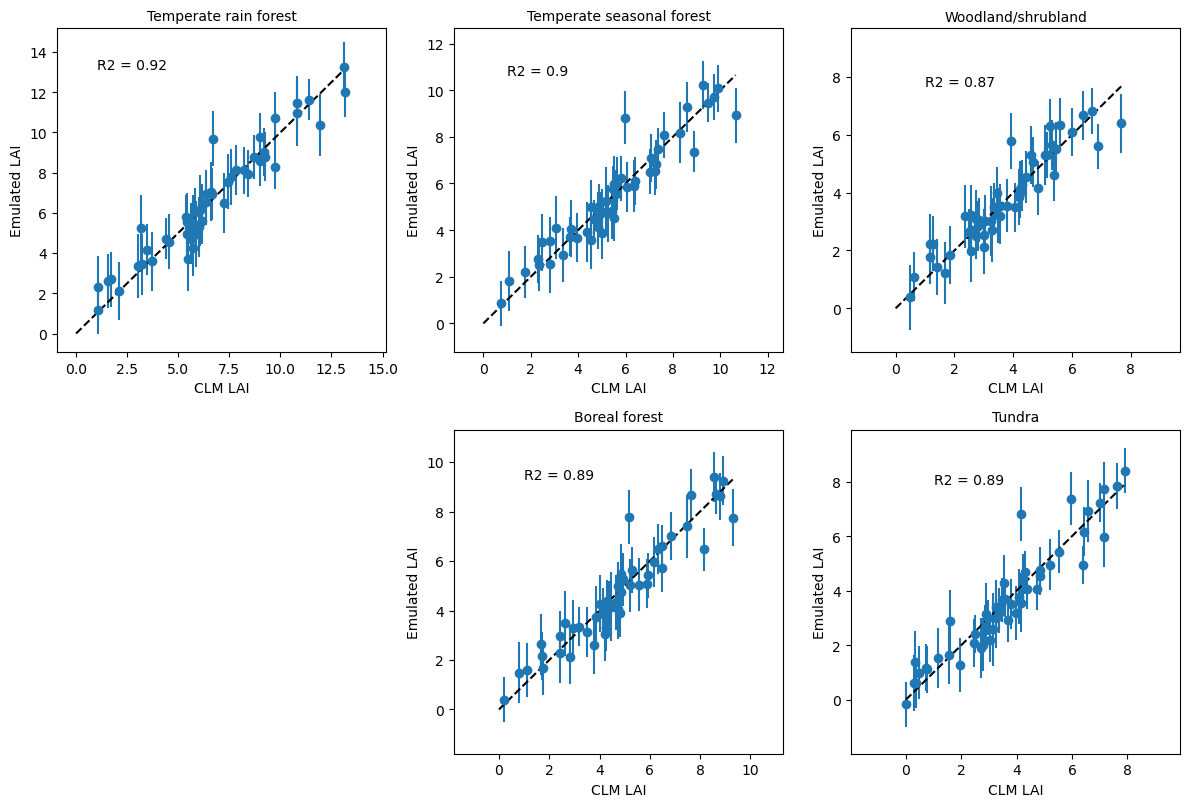

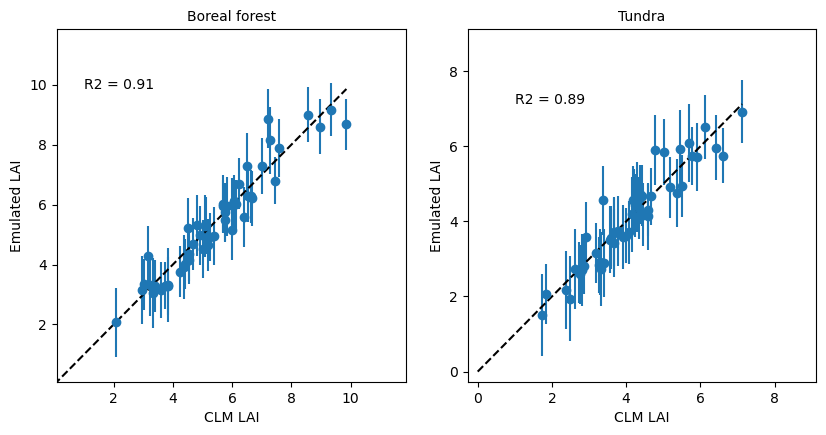

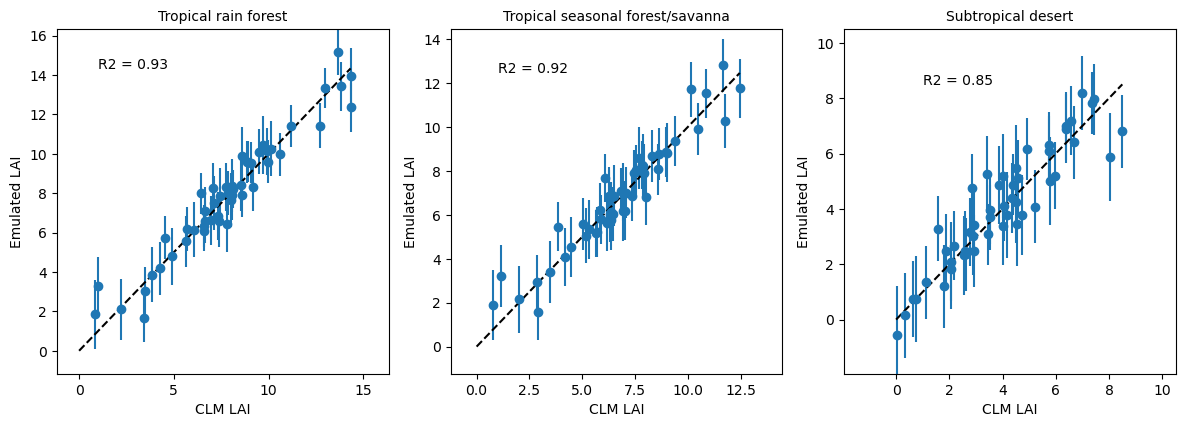

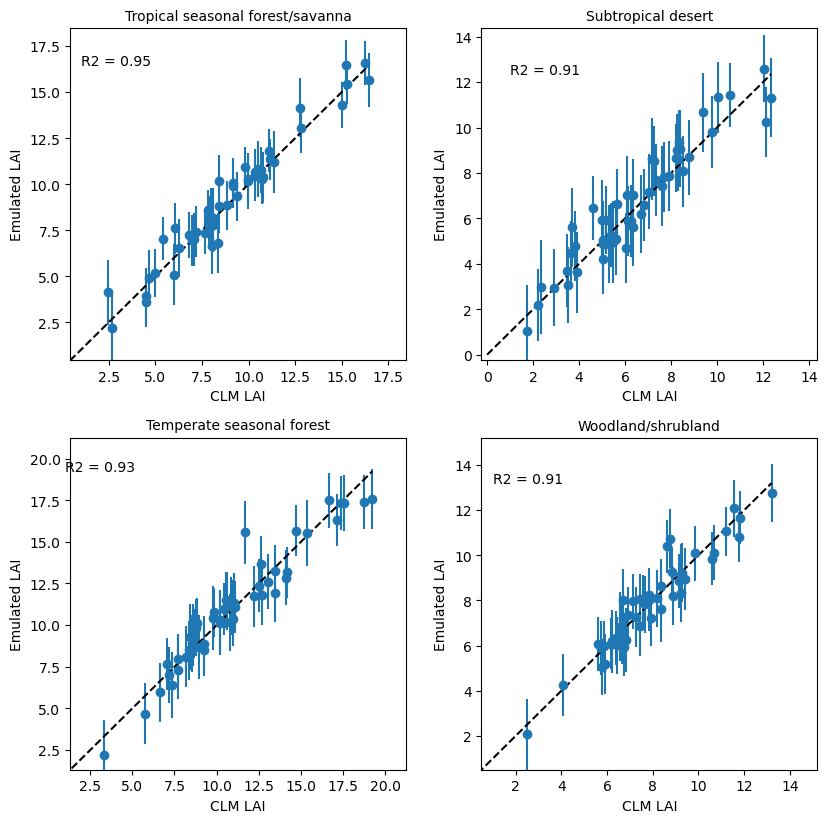

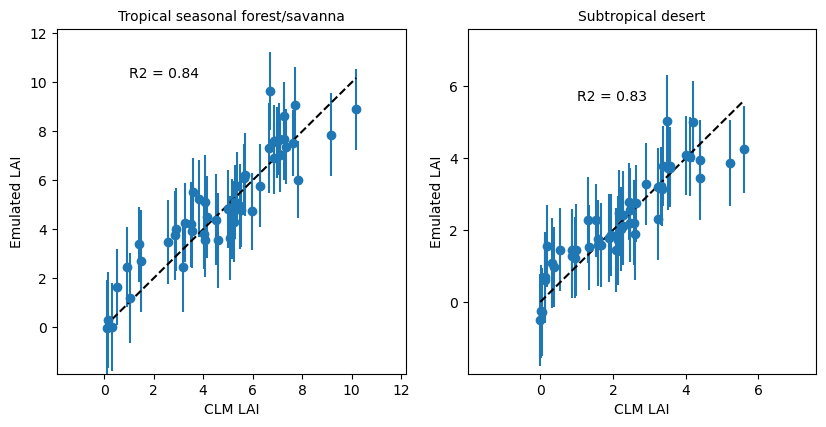

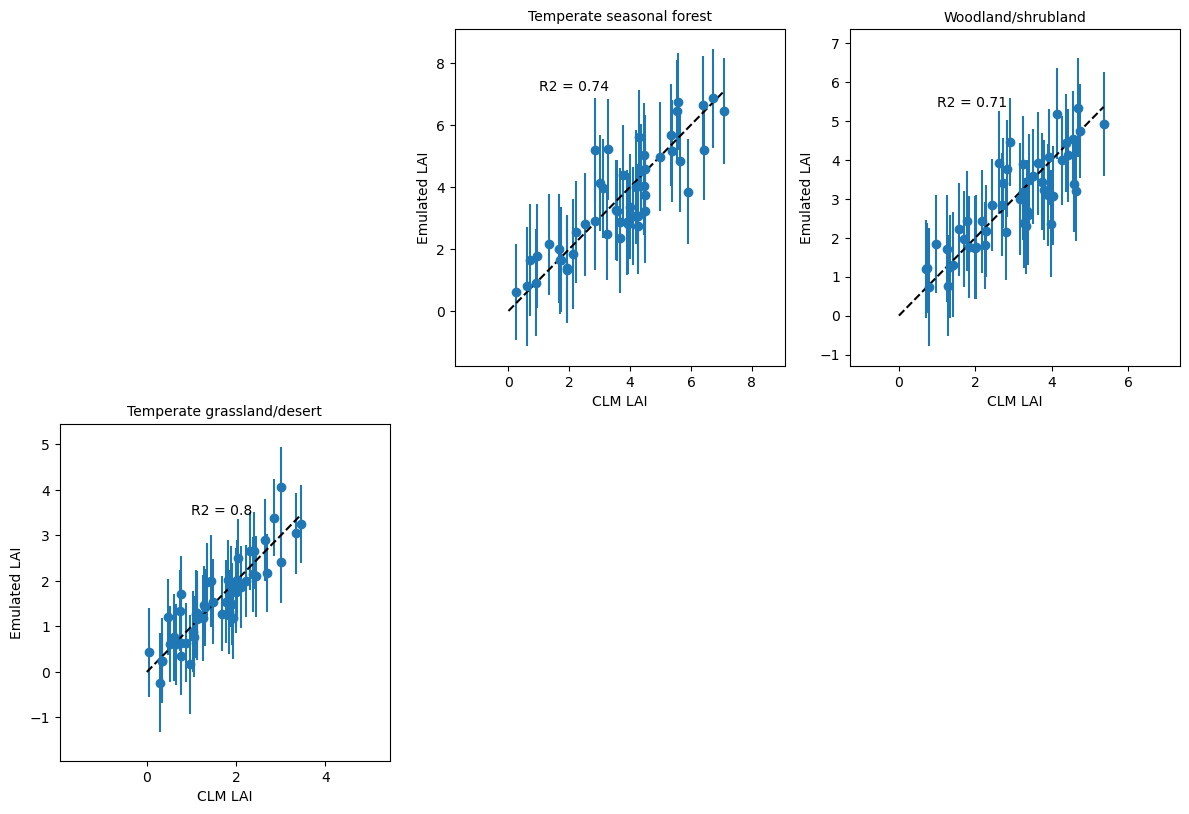

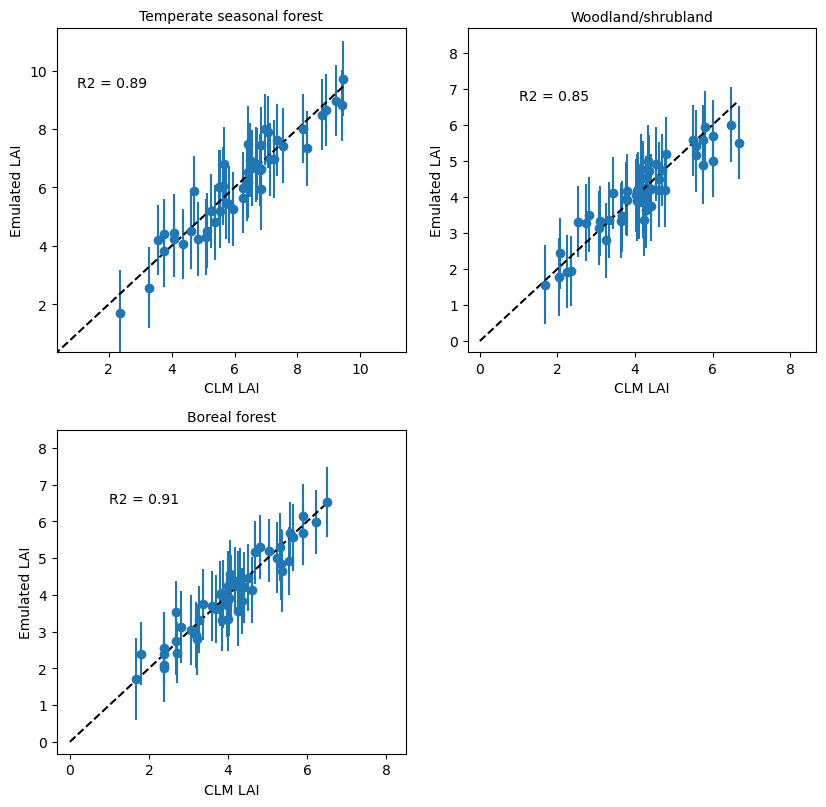

<Figure size 1200x1200 with 0 Axes>

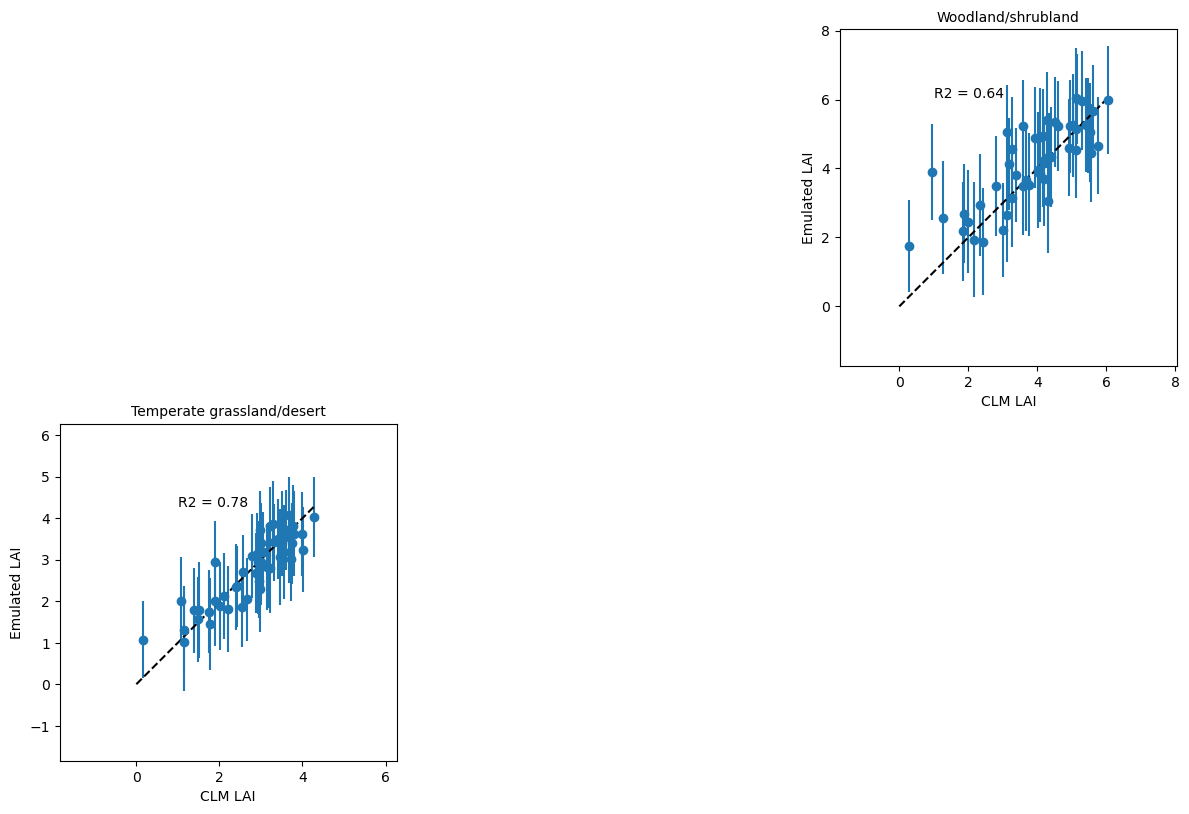

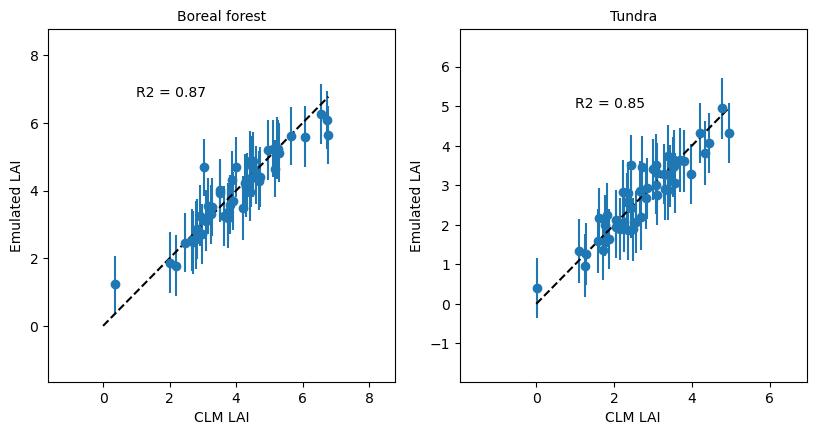

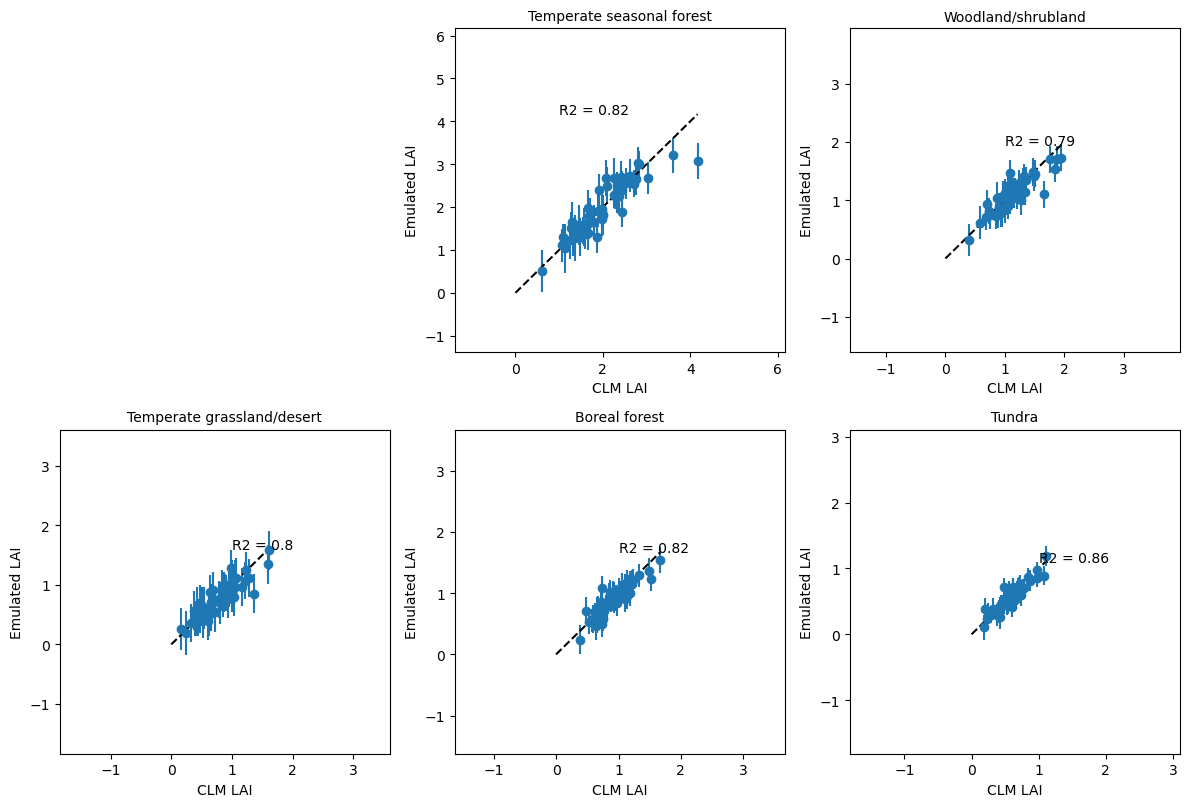

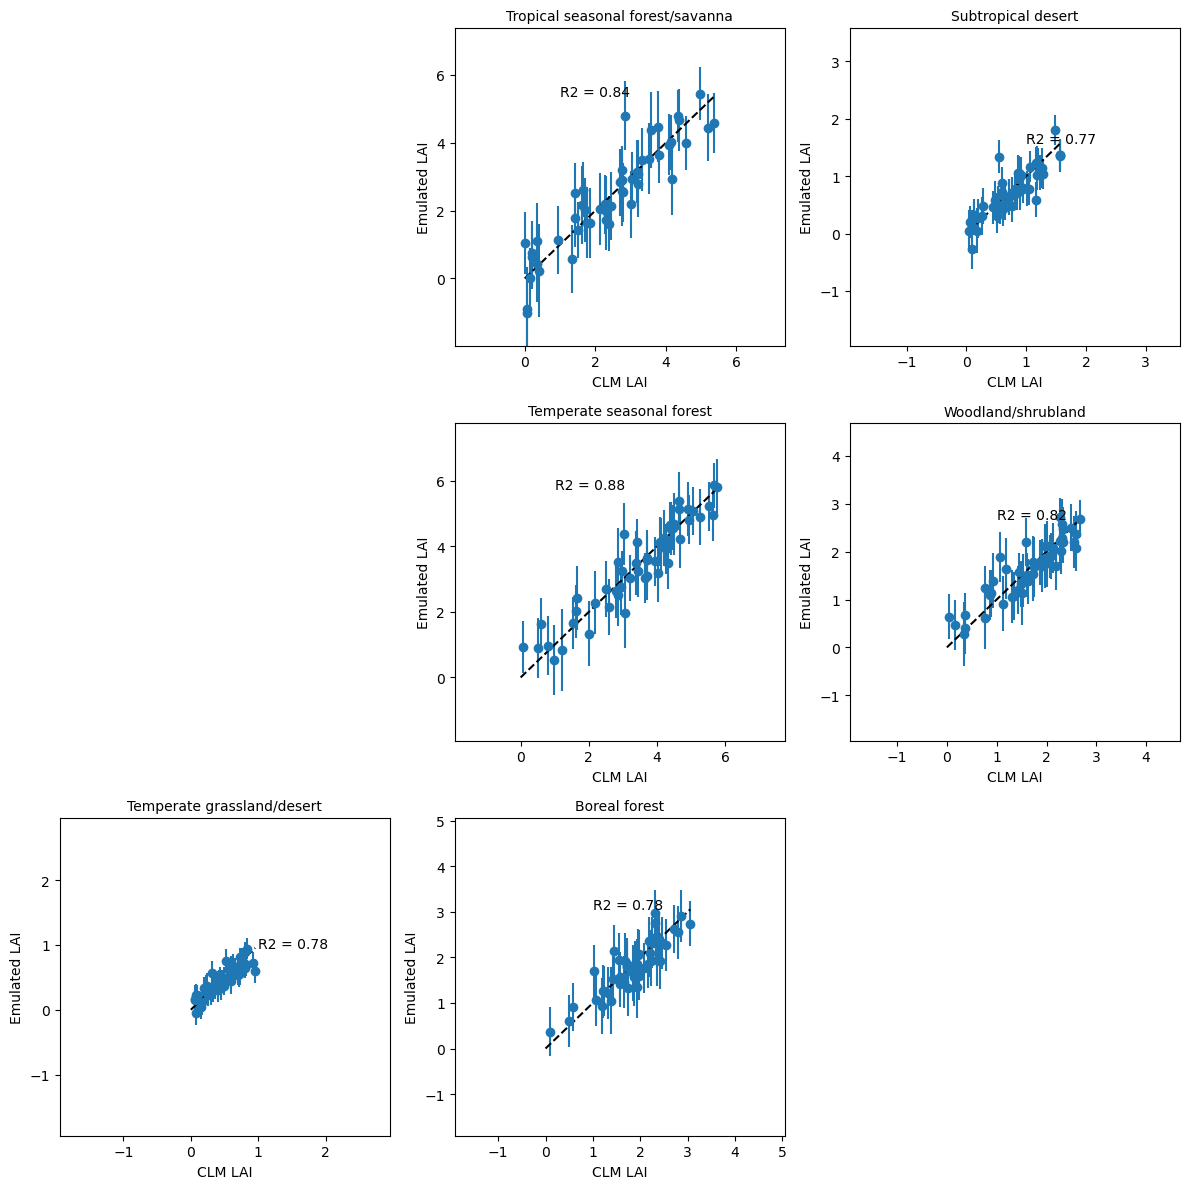

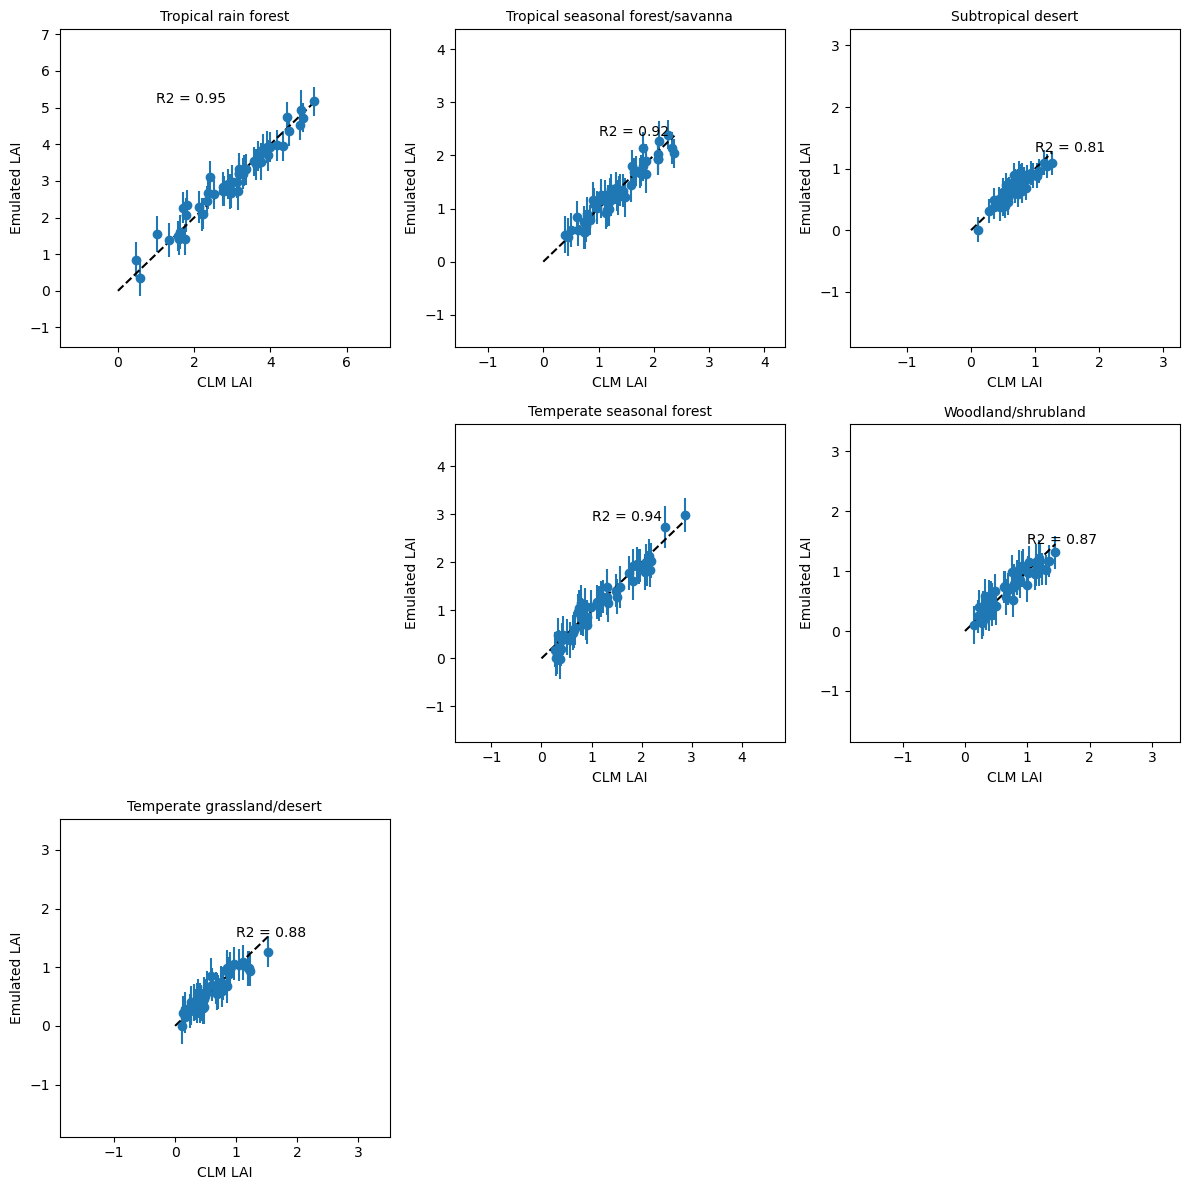

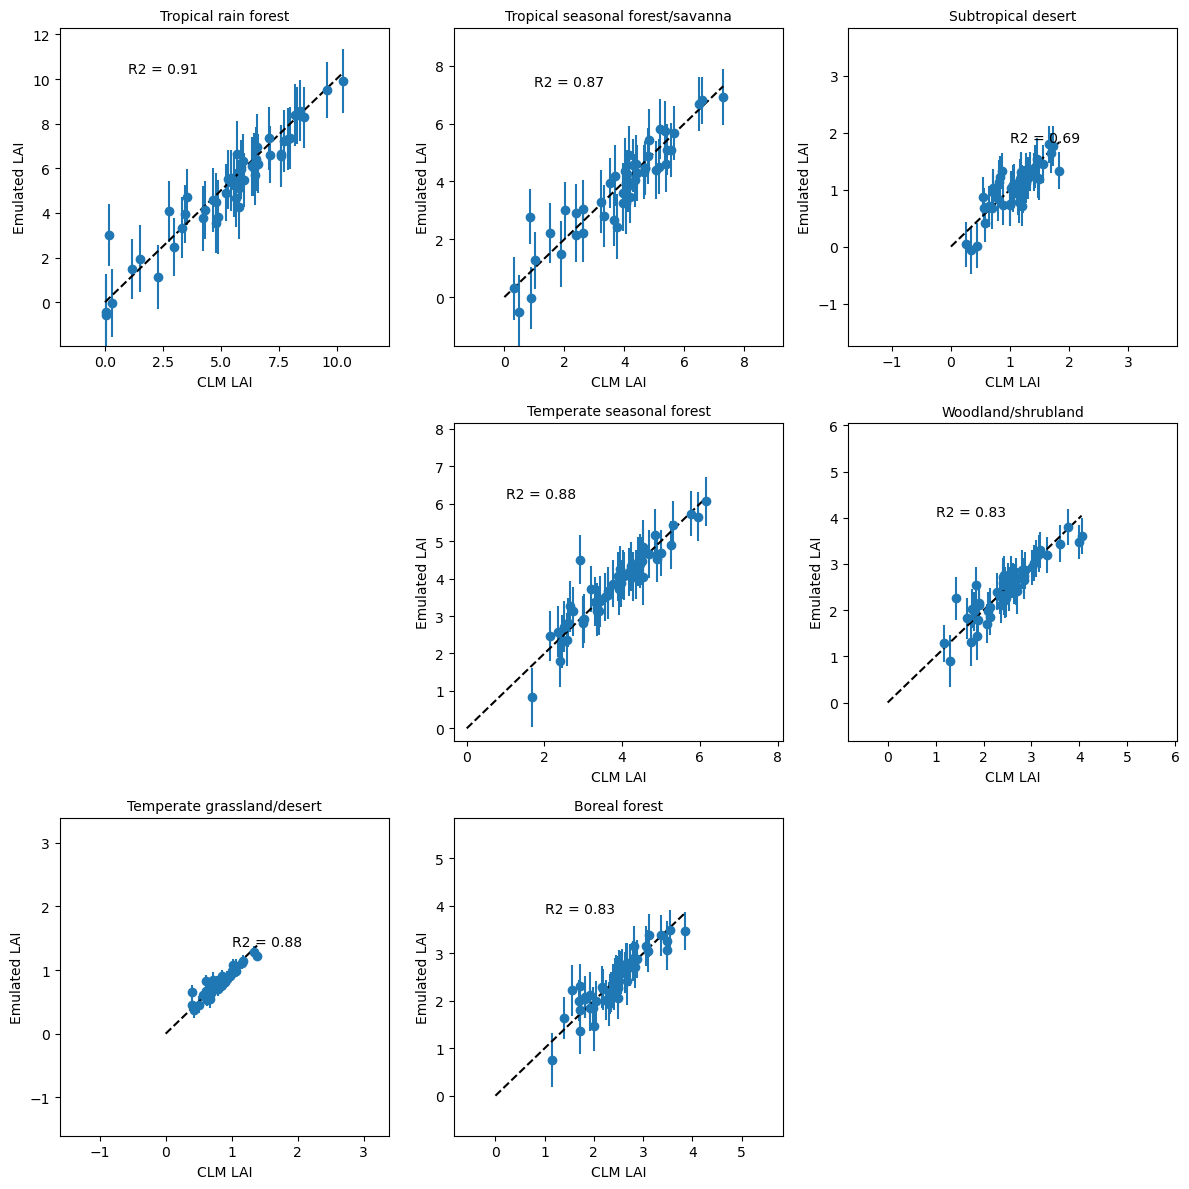

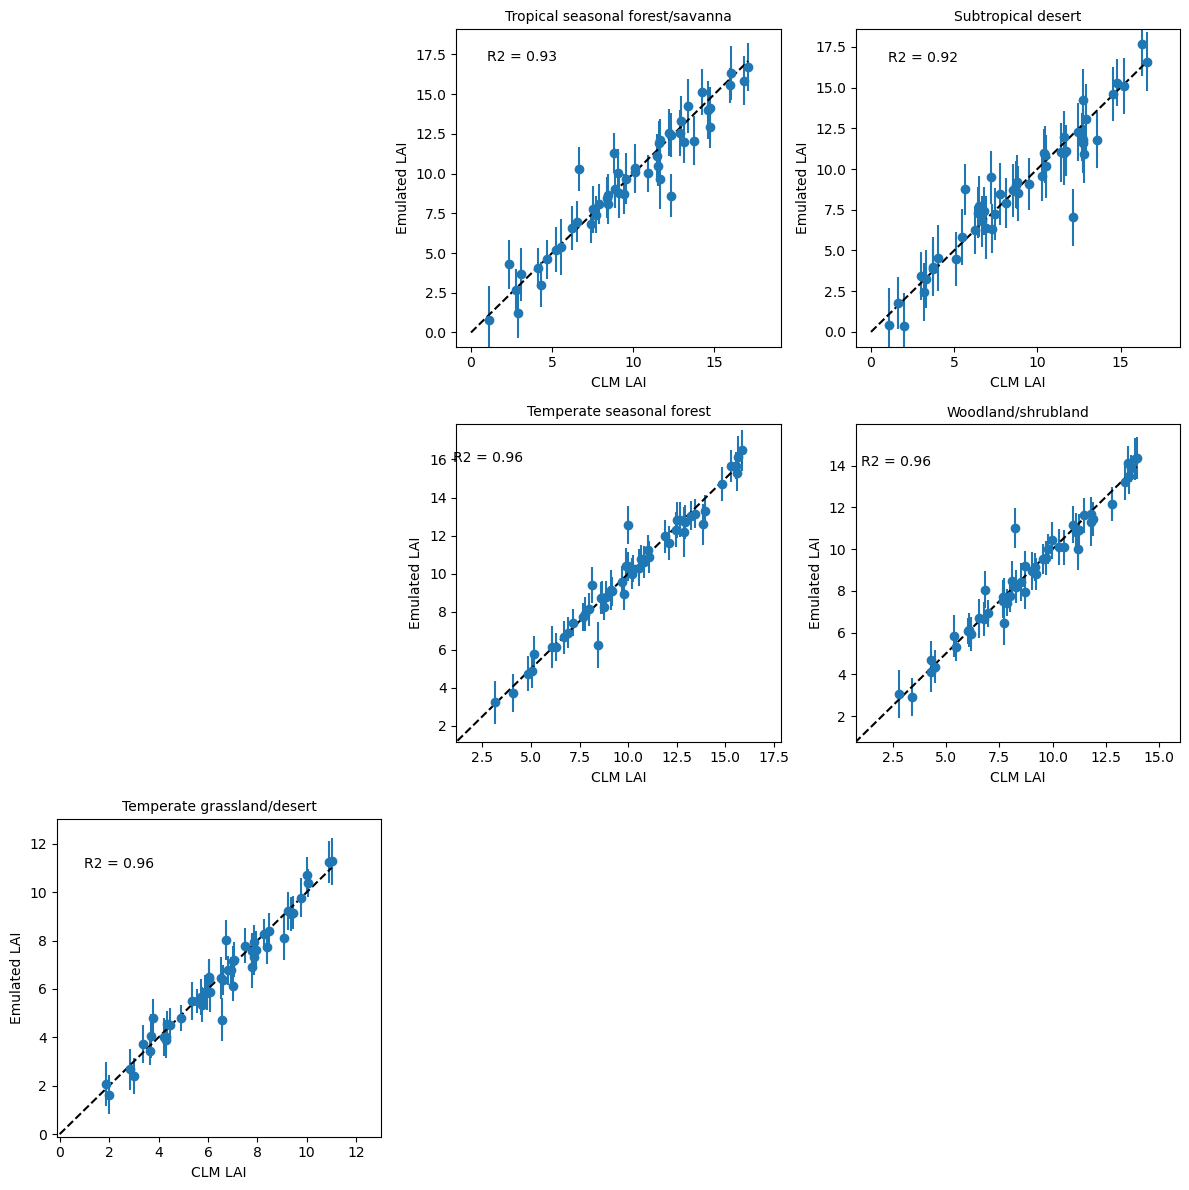

In [29]:
# Train emulators 
# For all TREE and SHRUB PFTs using annual maximum LAI
# For Grasses and crops, use annual mean LAI
R2_score = np.empty((17,10))*np.NaN
default_kernel = kernel_linear + kernel_RBF + kernel_poly + kernel_bias
grass_kernel = kernel_linear*kernel_RBF+kernel_matern32

for p in range(1,17):
    plt.figure(figsize=[12,12])
    plt.rcParams.update({'font.size': 10})

    if (p<12):
        da_p = laimax_pxb.isel(pxb=laimax_pxb.pft==p)
        kernel=default_kernel
    else: # grasses use annual mean LAI
        da_p = laimean_pxb.isel(pxb=laimean_pxb.pft==p)
        kernel = grass_kernel
    
    for i,b in enumerate(pb_index[pft_names[p]]):
        da_pb = da_p.isel(pxb=da_p.biome==b)

        X_train, X_test = lhc_params.iloc[50:,:].values, lhc_params.iloc[:50,:].values
        y_train, y_test = da_pb.TLAI[0][51:].values.reshape(-1,1), da_pb.TLAI[0][1:51].values.reshape(-1,1)
        
        model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=500))

        # save model
        model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
        savedir = str('./models_lai/pft'+str(p)+'_biome'+str(b))
        tf.saved_model.save(model, savedir)

        # plot validation
        y_pred, y_pred_var = model.predict_y(X_test)
        sd = y_pred_var.numpy().flatten()**0.5
        
        r = np.corrcoef(y_test.flatten(),y_pred.numpy().flatten())
        r2 = r[0,1]**2
        coef_deter = r2_score(y_test.flatten(),y_pred.numpy())
        R2_score[p,b] = coef_deter
        
        plt.subplot(3,3,b)
        plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
        plt.text(1,np.max(y_test.flatten()),'R2 = '+str(np.round(r2,2)),fontsize=10)
        plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_test.flatten())],linestyle='--',c='k')
        plt.xlabel('CLM LAI')
        plt.ylabel('Emulated LAI')
        plt.xlim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.ylim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.title(biome_names[b],fontsize=10)
        
    plt.tight_layout()
    plt.savefig('./figs/LAIemulator_validation_pft'+str(p)+'.png')

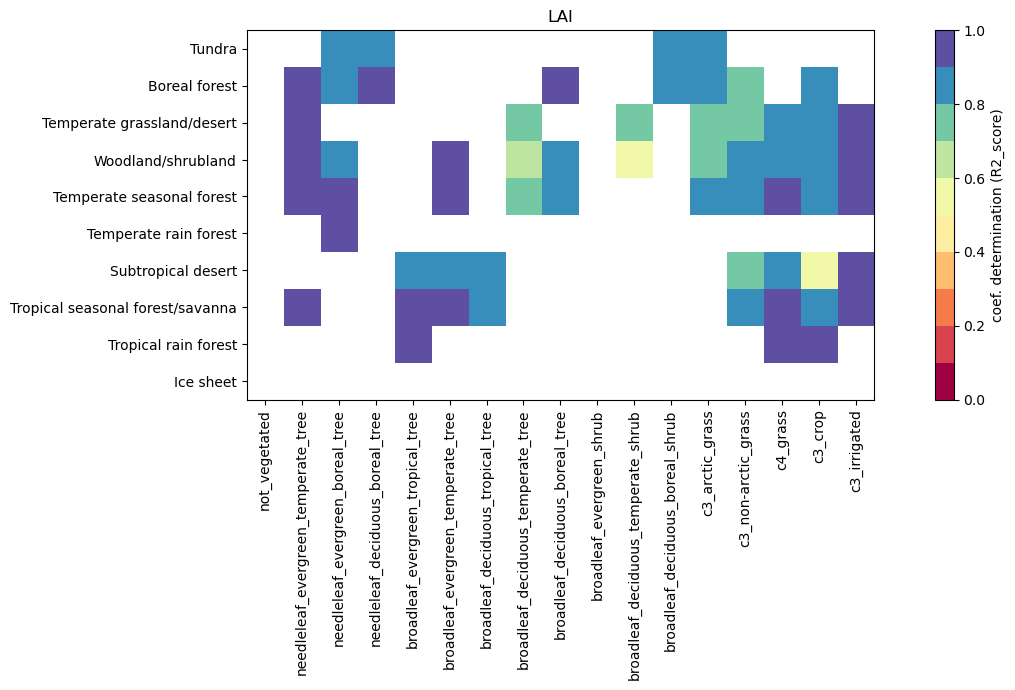

In [30]:
### Plot emulator evalutation
df_r2 = pd.DataFrame(R2_score)
df_r2.index = pft_names[0:17]
df_r2.columns = biome_names

plt.figure(num=None, figsize=(14, 7), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
data = df_r2.transpose().iloc[::-1]
cmap = plt.get_cmap('Spectral', 10)

im = ax.imshow(data,cmap=cmap,vmin=0,vmax=1)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(10), labels=data.index)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xticks(np.arange(17), labels=data.columns,rotation = 90)
plt.title('LAI')
plt.tight_layout()

cbar = plt.colorbar(im)
cbar.set_label("coef. determination (R2_score)")
plt.savefig('./figs/R2score_LAI_PxB.png')

In [31]:
# get land area
f='/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc'
lapxb=xr.open_dataset(f).lapxb
v = lapxb.sum(dim='pft').sel(year=slice(2007,2014)).mean(dim='year').compute()

la_array = v.isel(pxb=10*np.arange(1,16,1)).values
for b in range(1,10):
    ix = b+10*np.arange(1,16,1)
    new_column = v.isel(pxb=ix).values
    la_array = np.column_stack((la_array, new_column))


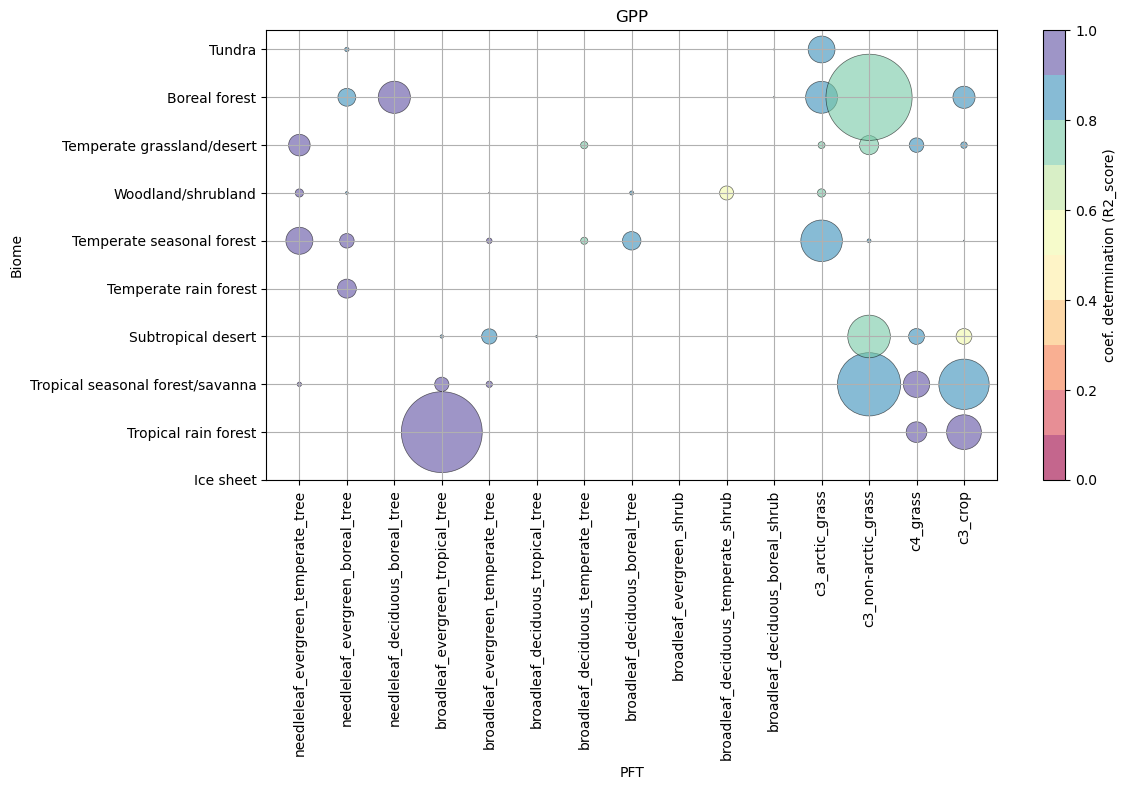

In [32]:
# same figure - scatter - sized by PxB land area
data = np.transpose(df_r2.iloc[range(1,16)].values)
num_rows, num_cols = data.shape

# Create X and Y index arrays using numpy.meshgrid
x_indices, y_indices = np.meshgrid(np.arange(num_cols), np.arange(num_rows))

# Flatten the index arrays and the data array
x_indices_flat = x_indices.flatten()
y_indices_flat = y_indices.flatten()
data_flat = data.flatten()

# Create scatter plot
plt.figure(num=None, figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
plt.scatter(x_indices_flat, y_indices_flat, c=data_flat, cmap=cmap, s=np.transpose(la_array)/3000, edgecolors='black', linewidths=0.5,alpha = 0.6, vmin=0,vmax=1)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(10), labels=df_r2.iloc[range(1,16)].columns)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xticks(np.arange(15), labels=df_r2.iloc[range(1,16)].index, rotation=90)
plt.title('GPP')
plt.tight_layout()

plt.colorbar(label='coef. determination (R2_score)')
plt.ylabel('Biome')
plt.xlabel('PFT')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/R2score_LAI_PxB_laScaled.png')